In [1]:
import functions
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from scipy.signal import  filtfilt, butter, iirnotch, find_peaks, sosfilt
from sklearn.decomposition import FastICA as skFastICA

In [2]:
fs=1000
span = 3000
offset = 100*fs 

### They apply BPF between 1, 50 with the CIC algorithm, but I don't have it

In [3]:
dd = functions.array_from_TDMSgroup("patients/P048/P048_S01_D2024-06-06_G26.tdms", "R001")
bp_data = functions.bandpass_filter(dd)
#bp_data = functions.butter_filter(dd)

### Apply ICA so to detect fetal and maternal signals, if we don't see them on ICA, nothing to do more

In [4]:
# normally, they were using deflation algorithm but parallel is much much faster, and produce similar results
sources, ica = functions.FASTICA(bp_data, n_comp=30, algo='parallel')

### After ICA, we need to detect fetal and maternal components for the heart rate analysis

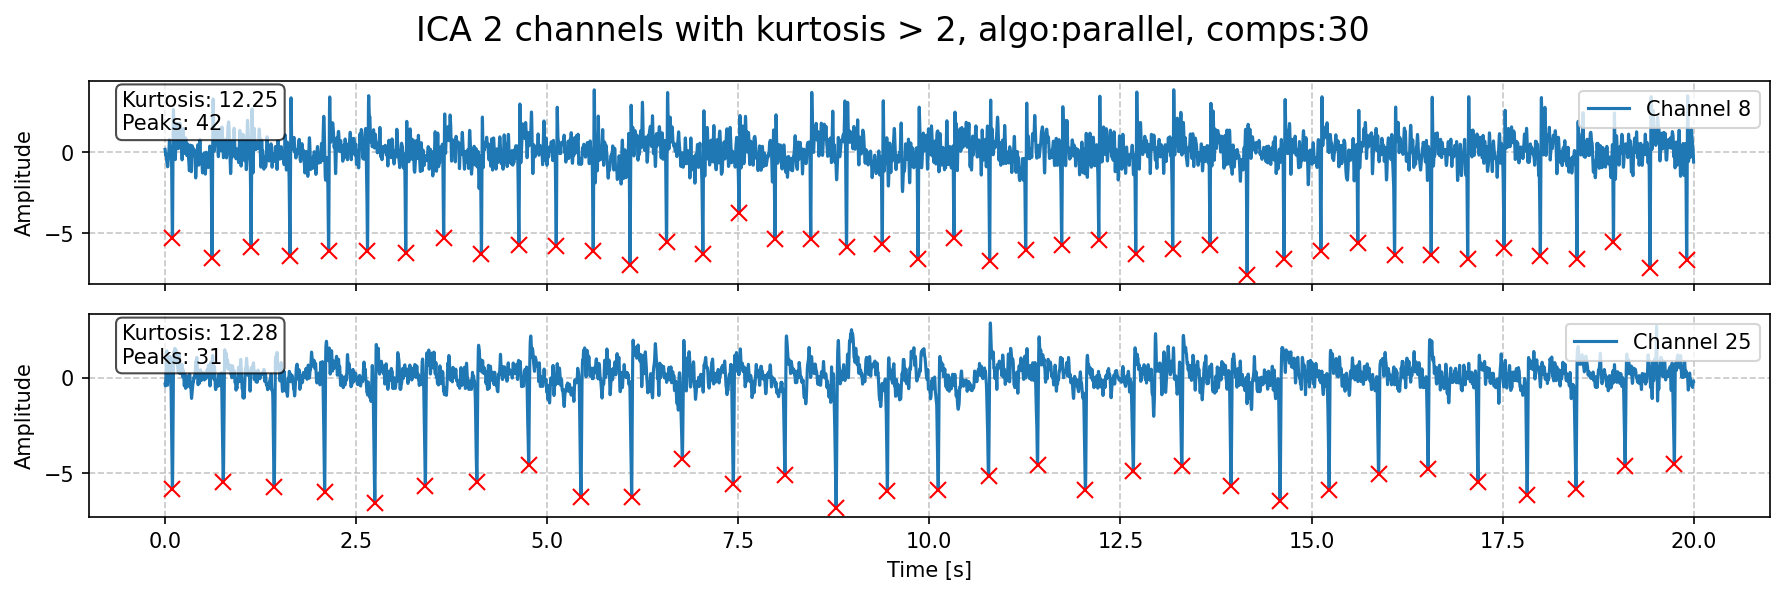

In [5]:
compF = functions.plotICA(sources, ica, offset= 0*fs, span=20*fs)

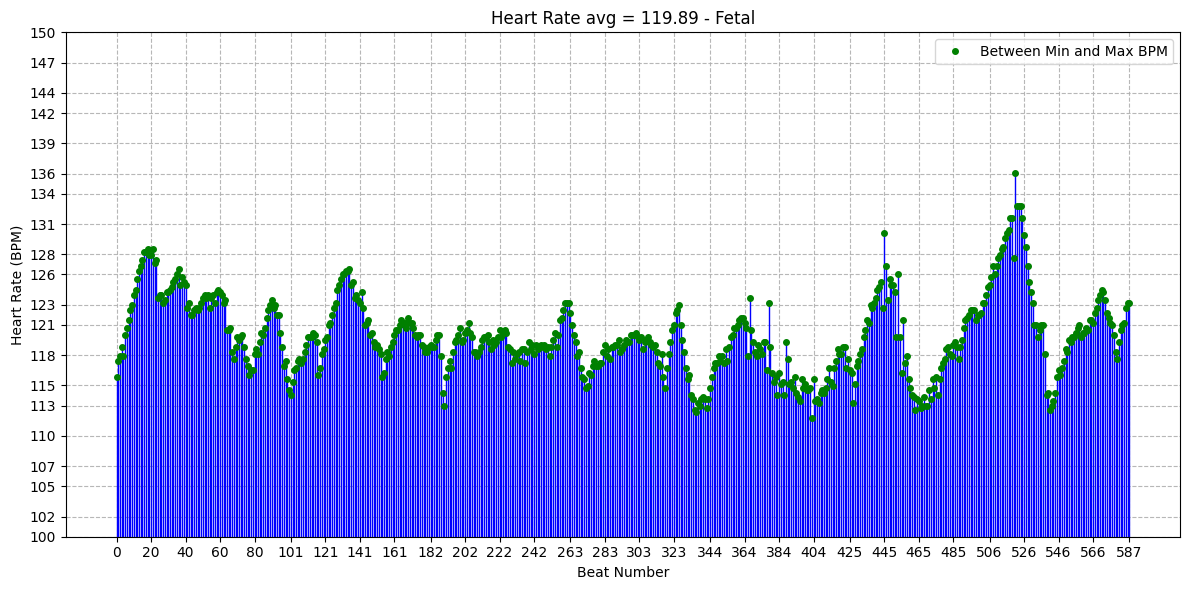

In [6]:

fetal_signal = sources[:, compF]
heartRate, peaksF = functions.plotHR(fetal_signal)


## I have to get somehow some predefined bpm range and only average on those otherwise they will cancel each other.

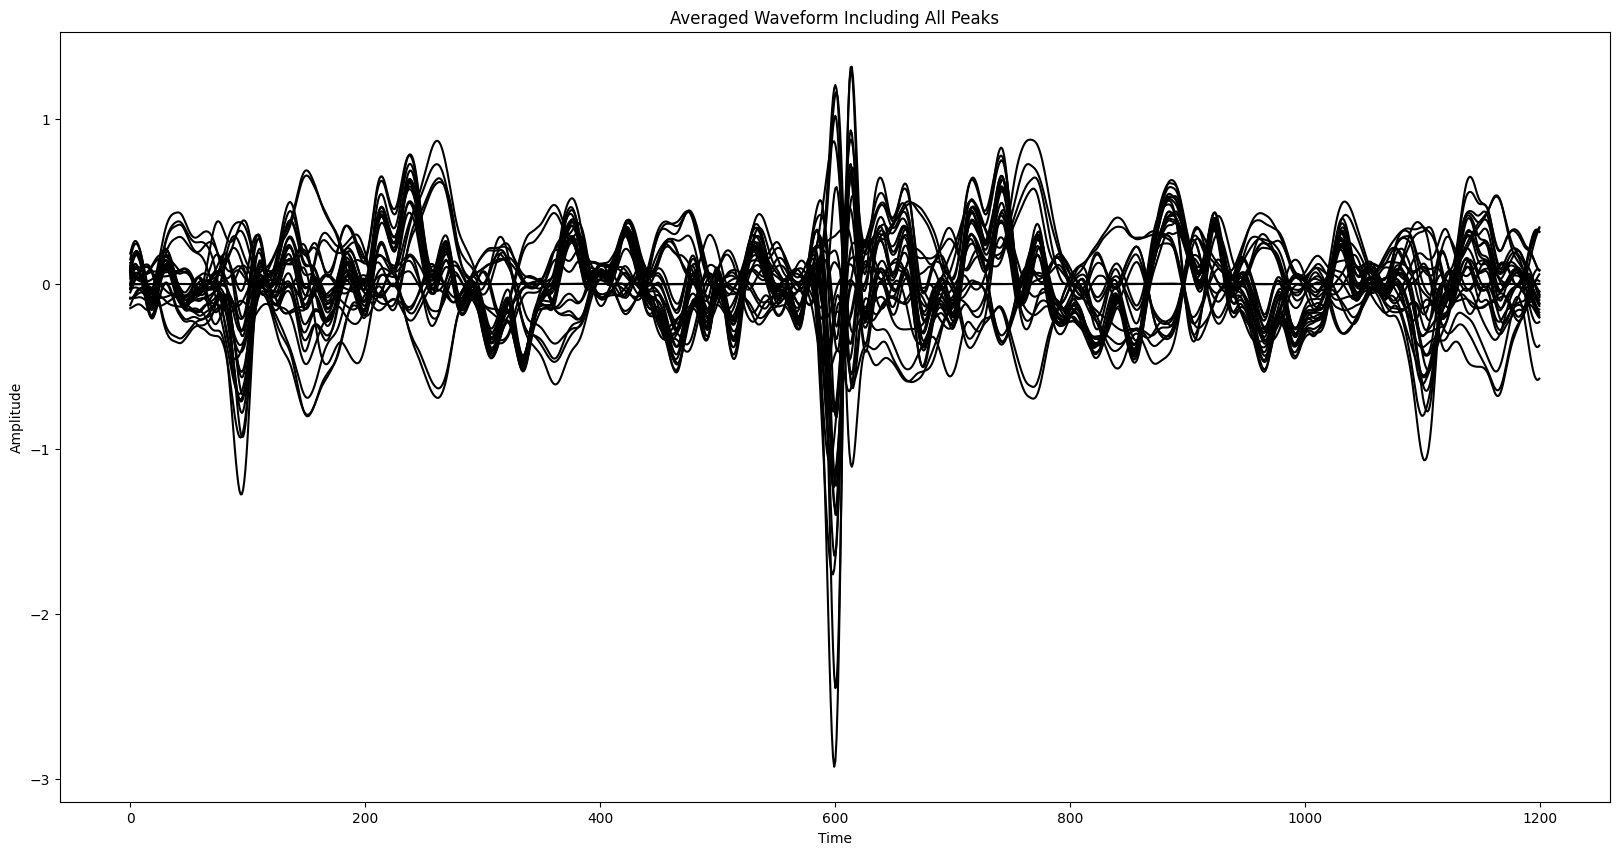

In [7]:
def avg_channels(data, peaks, window_size=1200):
    half_window = window_size // 2
    summed_waveforms = []
    for peak in peaks:
        start = peak - half_window
        end = peak + half_window
        if start < 0 or end >= len(data):
            continue
        window = data[start:end]
        summed_waveforms.append(window)
    
    if not summed_waveforms:
        return None
    
    # Average the waveforms point-wise
    averaged_waveform = np.mean(summed_waveforms, axis=0)
    return averaged_waveform

# Parameters
plt.figure(figsize=[20,10])
for ch in range(1, bp_data.shape[1]):
    plt.plot(avg_channels(bp_data[:, ch], peaksF), color = 'k')

plt.title("Averaged Waveform Including All Peaks")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


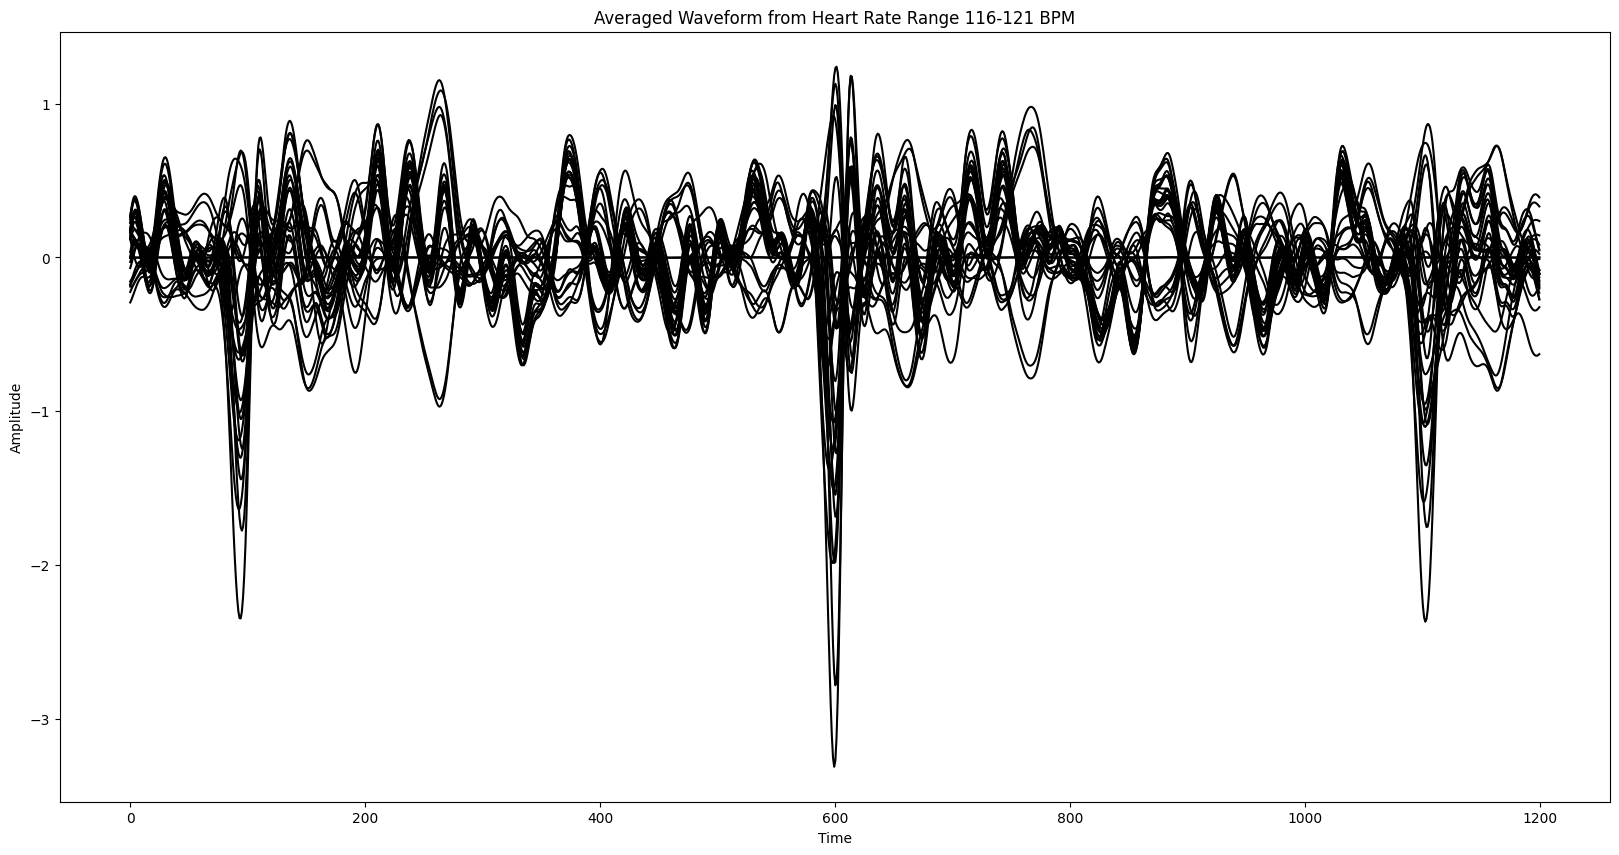

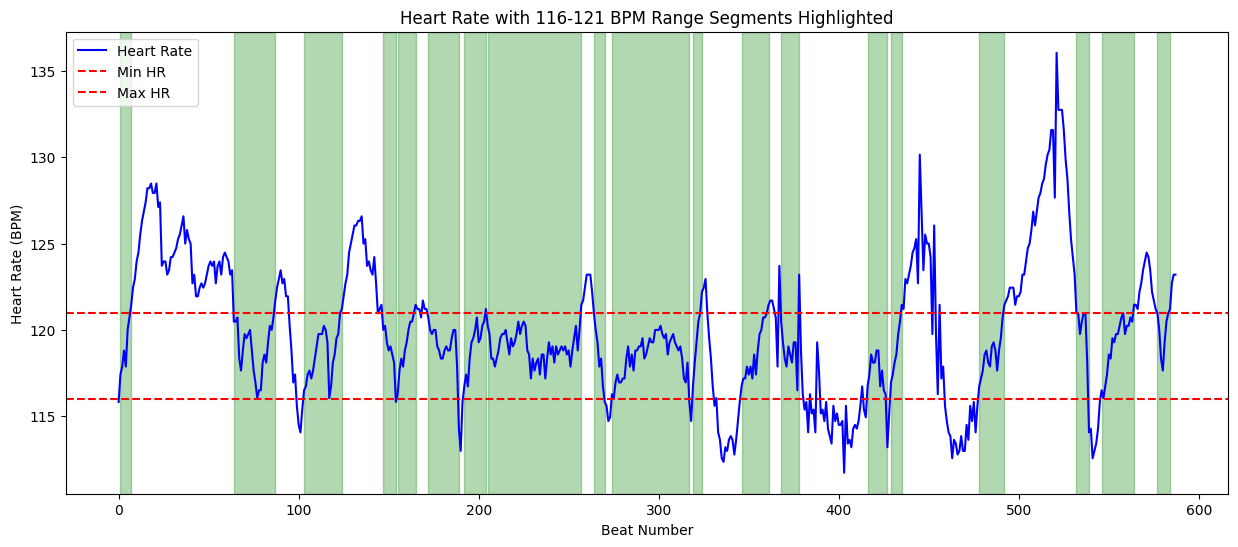

In [8]:

def identify_hr_range_segments(heart_rates, peaks, min_hr=116, max_hr=121, min_segment_length=5):
    range_segments = []
    start_index = None
    
    for i, hr in enumerate(heart_rates):
        if min_hr <= hr <= max_hr:
            if start_index is None:
                start_index = i
        else:
            if start_index is not None:
                if i - start_index >= min_segment_length:
                    range_segments.append((start_index, i))
                start_index = None
    
    # Check if the last segment extends to the end
    if start_index is not None and len(heart_rates) - start_index >= min_segment_length:
        range_segments.append((start_index, len(heart_rates)))
    
    return range_segments

def avg_channels_hr_range(data, peaks, heart_rates, window_size=1200, min_hr=116, max_hr=121):
    half_window = window_size // 2
    range_segments = identify_hr_range_segments(heart_rates, peaks, min_hr, max_hr)
    
    summed_waveforms = []
    for start, end in range_segments:
        segment_peaks = peaks[start:end]
        for peak in segment_peaks:
            if peak - half_window < 0 or peak + half_window >= len(data):
                continue
            window = data[peak - half_window : peak + half_window]
            summed_waveforms.append(window)
    
    if not summed_waveforms:
        return None
    
    averaged_waveform = np.mean(summed_waveforms, axis=0)
    return averaged_waveform

# Use the new function in your main code
plt.figure(figsize=[20,10])

for ch in range(1, bp_data.shape[1]):
    averaged_waveform = avg_channels_hr_range(bp_data[:, ch], peaksF, heartRate, min_hr=116, max_hr=121)
    if averaged_waveform is not None:
        plt.plot(averaged_waveform, color='k')
plt.title("Averaged Waveform from Heart Rate Range 116-121 BPM")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# Visualize the selected HR range segments
range_segments = identify_hr_range_segments(heartRate, peaksF, min_hr=116, max_hr=121)
plt.figure(figsize=(15, 6))
plt.plot(heartRate, 'b-', label='Heart Rate')
for start, end in range_segments:
    plt.axvspan(start, end, color='green', alpha=0.3)
plt.axhline(y=116, color='r', linestyle='--', label='Min HR')
plt.axhline(y=121, color='r', linestyle='--', label='Max HR')
plt.title("Heart Rate with 116-121 BPM Range Segments Highlighted")
plt.xlabel("Beat Number")
plt.ylabel("Heart Rate (BPM)")
plt.legend()
plt.show()

In [17]:
import pywt
def wavelet_denoise(averaged_waveform, wavelet='db4', level=5):
    coeffs = pywt.wavedec(averaged_waveform, wavelet, level=level)
    coeffs[1:] = [pywt.threshold(c, value=0.7, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)


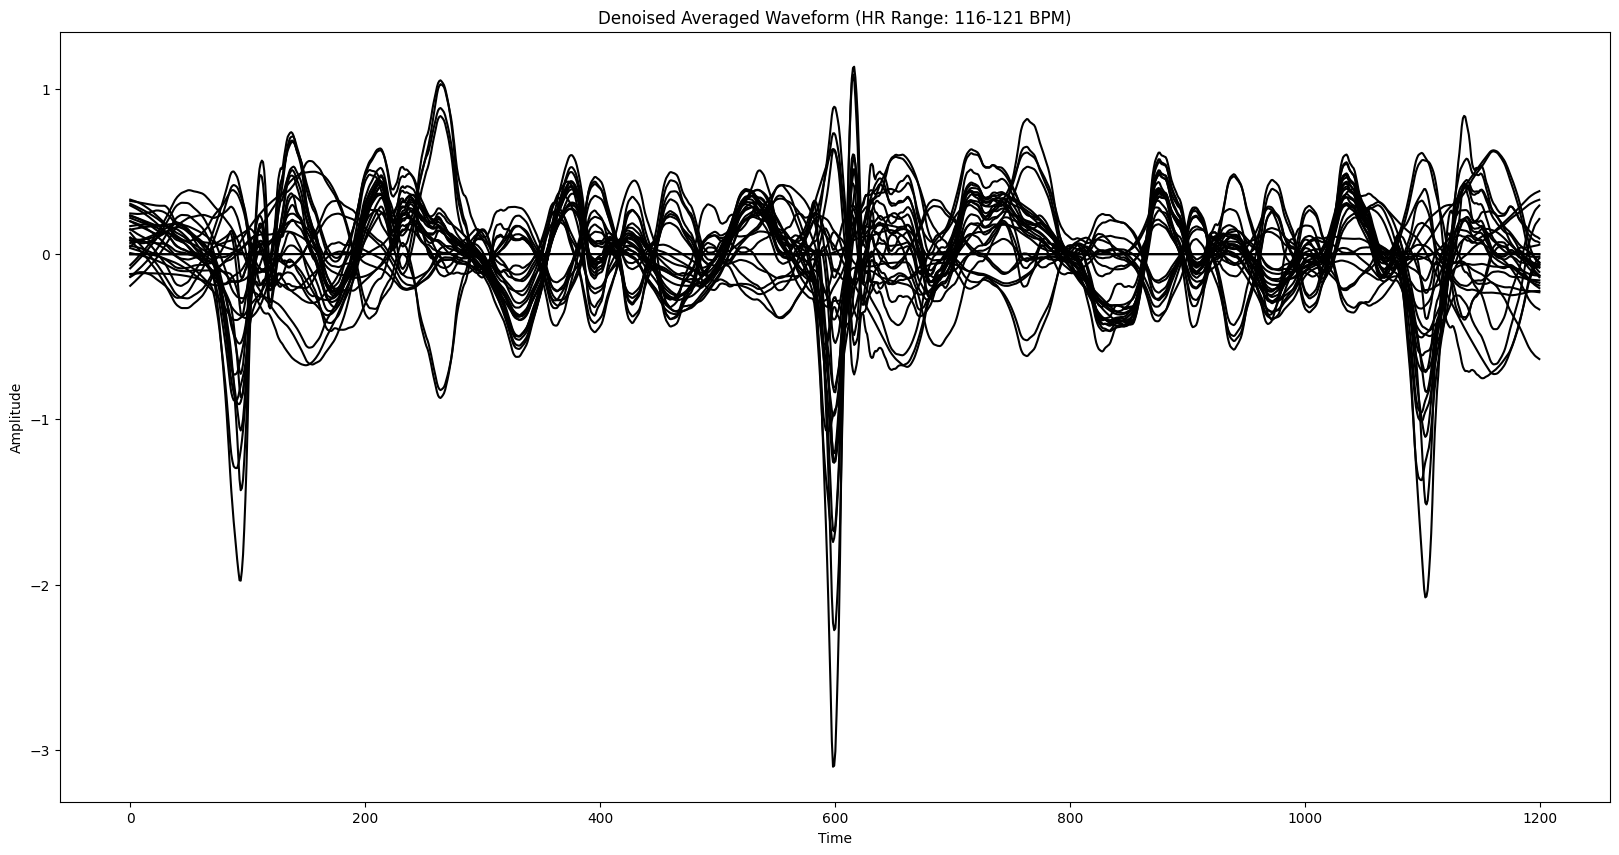

In [18]:

# Use in your main code
plt.figure(figsize=[20,10])
for ch in range(1, bp_data.shape[1]):
    averaged_waveform = avg_channels_hr_range(bp_data[:, ch], peaksF, heartRate, min_hr=116, max_hr=121)
    if averaged_waveform is not None:
        denoised_waveform = wavelet_denoise(averaged_waveform)
        plt.plot(denoised_waveform, color='k')
plt.title("Denoised Averaged Waveform (HR Range: 116-121 BPM)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()